In [1]:
from copy import deepcopy

import matplotlib.pyplot as plt
import pandas as pd
from elasticsearch import Elasticsearch
import seaborn as sns

from algorithm.co_occ import IterConstructor, BFSConstructor
from algorithm.const import *
from algorithm.profile import profile


%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# 设置中文字体，并保证负号正常显示

plt.rcParams['font.sans-serif'] = ['Calibri']
plt.rcParams['axes.unicode_minus'] = False



In [2]:
es = Elasticsearch("http://127.0.0.1:9204")
es.info()

ObjectApiResponse({'name': 'node0', 'cluster_name': 'docbase', 'cluster_uuid': '63TQlJkjRvyY3NtujxmYuQ', 'version': {'number': '8.6.1', 'build_flavor': 'default', 'build_type': 'zip', 'build_hash': '180c9830da956993e59e2cd70eb32b5e383ea42c', 'build_date': '2023-01-24T21:35:11.506992272Z', 'build_snapshot': False, 'lucene_version': '9.4.2', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'})

In [3]:
constructors = [
    IterConstructor(client=es),
    BFSConstructor(client=es, depth=10)
]
constructors


[0x2B49FC35E80 co_occ_test content, 0x2B4FE406400 co_occ_test content]

In [4]:
top_words = {
    "top_words": {
        "terms": {
            "field": "content",
            "size": 200,
        }
    }
}
res = es.search(
    index=DEFAULT_INDEX,
    aggs=top_words, size=0
)
buckets = [
    bucket for bucket in
    res["aggregations"]["top_words"]["buckets"]
    if len(bucket["key"]) > 1
]
buckets

[{'key': '图书馆', 'doc_count': 667},
 {'key': '研究', 'doc_count': 465},
 {'key': '我国', 'doc_count': 445},
 {'key': '思考', 'doc_count': 341},
 {'key': '报道', 'doc_count': 333},
 {'key': '高校图书馆', 'doc_count': 333},
 {'key': '中国', 'doc_count': 297},
 {'key': '新闻', 'doc_count': 248},
 {'key': '发展', 'doc_count': 217},
 {'key': '分析', 'doc_count': 196},
 {'key': '影响', 'doc_count': 183},
 {'key': '传播', 'doc_count': 180},
 {'key': '电视', 'doc_count': 178},
 {'key': '启示', 'doc_count': 164},
 {'key': '探析', 'doc_count': 164},
 {'key': '公共图书馆', 'doc_count': 162},
 {'key': '创新', 'doc_count': 160},
 {'key': '媒体', 'doc_count': 158},
 {'key': '实践', 'doc_count': 155},
 {'key': '美国', 'doc_count': 150},
 {'key': '试论', 'doc_count': 136},
 {'key': '传媒', 'doc_count': 130},
 {'key': '数字图书馆', 'doc_count': 130},
 {'key': '信息', 'doc_count': 128},
 {'key': '探讨', 'doc_count': 127},
 {'key': '探索', 'doc_count': 123},
 {'key': '网络环境下', 'doc_count': 123},
 {'key': '媒介', 'doc_count': 118},
 {'key': '构建', 'doc_count': 117},
 

In [5]:
profiles = []
for constructor in constructors:
    for bucket in buckets:
        query = {
            "bool": {
                "must": [
                    {
                        "wildcard": {
                            DEFAULT_FIELD: f"*{bucket['key']}*"
                        }
                    }
                ]
            }
        }
        constructor = profile(constructor)
        network_t = constructor.get_network_time(query)
        network_m = constructor.get_network_memory(query)
        bucket["time"] = network_t.time
        bucket["memory"] = network_m.memory
        bucket["algorithm"] = str(type(constructor))
        profiles.append(deepcopy(bucket))
profiles

[{'key': '图书馆',
  'doc_count': 667,
  'time': 2.6113541,
  'memory': 6949.1953125,
  'algorithm': "<class 'algorithm.co_occ.IterConstructor'>"},
 {'key': '研究',
  'doc_count': 465,
  'time': 2.0487611,
  'memory': 7342.1953125,
  'algorithm': "<class 'algorithm.co_occ.IterConstructor'>"},
 {'key': '我国',
  'doc_count': 445,
  'time': 0.49603669999999767,
  'memory': 1924.640625,
  'algorithm': "<class 'algorithm.co_occ.IterConstructor'>"},
 {'key': '思考',
  'doc_count': 341,
  'time': 0.6244792999999973,
  'memory': 2701.9375,
  'algorithm': "<class 'algorithm.co_occ.IterConstructor'>"},
 {'key': '报道',
  'doc_count': 333,
  'time': 0.7083589000000003,
  'memory': 4512.4765625,
  'algorithm': "<class 'algorithm.co_occ.IterConstructor'>"},
 {'key': '高校图书馆',
  'doc_count': 333,
  'time': 0.3389979999999966,
  'memory': 961.4375,
  'algorithm': "<class 'algorithm.co_occ.IterConstructor'>"},
 {'key': '中国',
  'doc_count': 297,
  'time': 0.9661809999999988,
  'memory': 5573.3046875,
  'algorithm

In [6]:
profile_data = pd.DataFrame(profiles)
profile_data

,key,doc_count,time,memory,algorithm
0,图书馆,667,2.611354,6949.195312,<class 'algorithm.co_occ.IterConstructor'>
1,研究,465,2.048761,7342.195312,<class 'algorithm.co_occ.IterConstructor'>
2,我国,445,0.496037,1924.640625,<class 'algorithm.co_occ.IterConstructor'>
3,思考,341,0.624479,2701.937500,<class 'algorithm.co_occ.IterConstructor'>
4,报道,333,0.708359,4512.476562,<class 'algorithm.co_occ.IterConstructor'>
...,...,...,...,...,...
369,国家,35,0.184149,49.937500,<class 'algorithm.co_occ.BFSConstructor'>
370,比较分析,35,0.233336,38.046875,<class 'algorithm.co_occ.BFSConstructor'>
371,节目,35,0.233268,152.601562,<class 'algorithm.co_occ.BFSConstructor'>
372,调查分析,35,0.235683,36.062500,<class 'algorithm.co_occ.BFSConstructor'>


In [7]:
profile_iter = profile_data[profile_data["algorithm"] == str(type(constructors[0]))]
profile_bfs = profile_data[profile_data["algorithm"] == str(type(constructors[1]))]
profile_iter.describe()

,doc_count,time,memory
count,187.000000,187.000000,187.000000
mean,78.962567,0.255606,1013.743023
std,80.005939,0.400179,1338.125302
min,35.000000,0.038351,74.109375
25%,40.500000,0.070604,308.957031
50%,50.000000,0.118077,545.070312
75%,79.000000,0.243738,1053.769531
max,667.000000,2.611354,7414.390625


In [8]:
profile_bfs.describe()

,doc_count,time,memory
count,187.000000,187.000000,187.000000
mean,78.962567,0.214520,64.838277
std,80.005939,0.038827,30.430193
min,35.000000,0.084877,26.078125
25%,40.500000,0.195030,42.652344
50%,50.000000,0.222652,52.734375
75%,79.000000,0.238208,81.941406
max,667.000000,0.315829,170.585938


<Axes: xlabel='doc_count', ylabel='memory'>

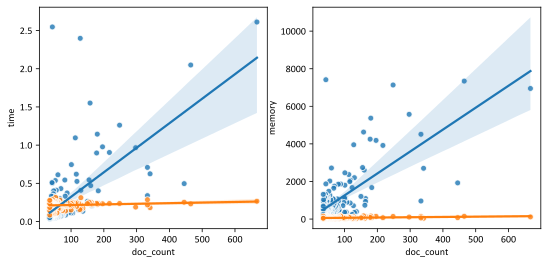

In [9]:
fig, axes = plt.subplots(1,2, figsize=(9,4))

ax = axes[0]
sns.regplot(
    data=profile_iter,
    x="doc_count", y="time", ax=ax,
    scatter_kws={"linewidth":1, "edgecolor":"w"}
)
sns.regplot(
    data=profile_bfs,
    x="doc_count", y="time", ax=ax,
    scatter_kws={"linewidth":1, "edgecolor":"w"}
)


ax = axes[1]
sns.regplot(
    data=profile_iter,
    x="doc_count", y="memory", ax=ax,
    scatter_kws={"linewidth":1, "edgecolor":"w"}
)
sns.regplot(
    data=profile_bfs,
    x="doc_count", y="memory", ax=ax,
    scatter_kws={"linewidth":1, "edgecolor":"w"}
)
